In [28]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

from scipy.ndimage import gaussian_filter, map_coordinates
from torchvision import transforms, datasets
import torch
import random
import numpy as np
from PIL import Image

import imageio

from OCT.oct import OCTDataset

In [21]:
def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003].
    
    Parameters:
        image (numpy.ndarray): Input image.
        alpha (float): Scale of the transformation. Larger values have more deformation.
        sigma (float): Standard deviation of the Gaussian filter. Controls smoothness of the deformation.
        random_state (int, optional): Random seed for reproducibility.
        
    Returns:
        numpy.ndarray: Deformed image.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
        

    distorted_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distorted_image.reshape(image.shape)

def apply_elastic_deformation(img, alpha=1, sigma=4):
    print("a")
    """Apply elastic deformation on the input image."""
    img_np = np.array(img)
    deformed_img_np = elastic_transform(img_np, alpha, sigma)
    deformed_img = Image.fromarray(deformed_img_np.astype('uint8'))
    
    if deformed_img.size != img.size:
        deformed_img = deformed_img.resize(img.size)
    return deformed_img

In [29]:
oct_transforms = transforms.Compose([
        transforms.RandomRotation(degrees=10),  # Slightly larger rotation
        transforms.RandomResizedCrop(size=(64, 64), scale=(0.75, 1.0)),  # Adjust the cropping scale
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.3),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
        transforms.Lambda(lambda img: apply_elastic_deformation(
    img,
    alpha=608,
    sigma=24.32,
) if random.random() < 0.5 else img),
        transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.32978319597], std=[0.10885790758])
    ])

In [30]:
oct_dataset = OCTDataset(directory="/app/Data/OCTA_3mm", patient_numbers=[10301], mm=3, transform=oct_transforms, label=True)

def show_image(ax, img, title=None):
    # If the image is a torch tensor, convert it to a PIL image
    if isinstance(img, torch.Tensor):
        img = ToPILImage()(img)
    ax.imshow(img, cmap='gray')
    if title:
        ax.set_title(title)
    ax.axis('off')

a
a


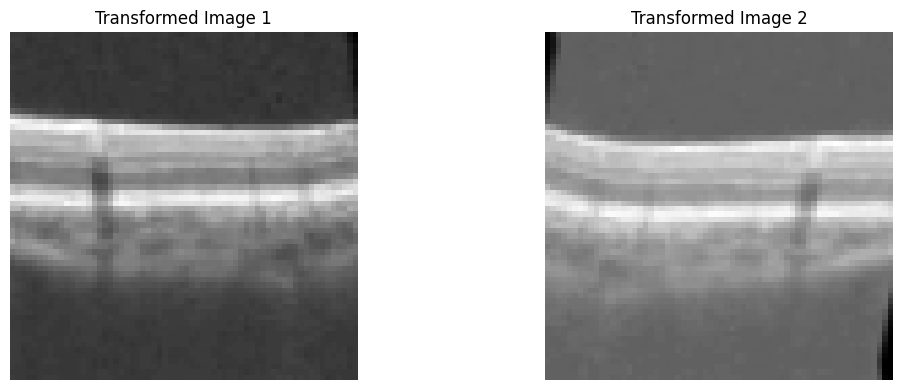

In [25]:
# Select an index to visualize
index = 0  # Change as needed
images, labels = oct_dataset[index]

# Setup plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
show_image(axes[0], images[0][0], title="Transformed Image 1")
show_image(axes[1], images[1][0], title="Transformed Image 2")

plt.tight_layout()
plt.show()

In [26]:
sigma

24.32

/tmp/ipykernel_152/3542522228.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)  # This line reads the image


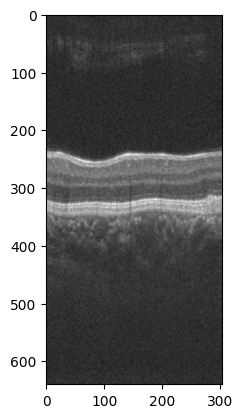

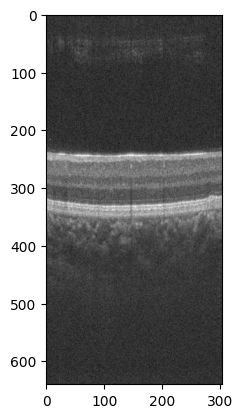

In [27]:
# Load your image
image_path = './10.bmp' # Update this path to your image
image = imageio.imread(image_path)  # This line reads the image

# If your image is not grayscale, convert it to grayscale
# This can be done using various methods, but here's a simple approach:
# image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])

# Apply elastic transformation
alpha = image.shape[1] * 2  # Scale of transformation
sigma = image.shape[1] * 0.08  # Smoothing factor
transformed_image = elastic_transform(image, alpha, sigma)

# Display the transformed image
plt.imshow(transformed_image, cmap='gray')
plt.show()

# Display the transformed image
plt.imshow(image, cmap='gray')
plt.show()
